[View in Colaboratory](https://colab.research.google.com/github/gr3ybr0w/cookbook/blob/master/Gradient_Boosting_Classifier.ipynb)

In [0]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, fbeta_score, confusion_matrix, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

from scipy.stats import norm
from scipy import stats

# Gradient Boosting Classifier

In this notebook I am going to be looking at the Gradient Boosting Classifier.

## Preprocessing:



*   Classes need to be numeric
*   Categorical features to numberic (dummies / one-hot encoding)
*   Removing of outliers
*   Scaling is not needed but might help
*   Handle nans
*   Remove duplicates




## How it works:

Gradient boosting involves three elements:

A loss function to be optimized.
A weak learner to make predictions.
An additive model to add weak learners to minimize the loss function.

1. Loss Function
The loss function used depends on the type of problem being solved.

It must be differentiable, but many standard loss functions are supported and you can define your own.

For example, regression may use a squared error and classification may use logarithmic loss.

A benefit of the gradient boosting framework is that a new boosting algorithm does not have to be derived for each loss function that may want to be used, instead, it is a generic enough framework that any differentiable loss function can be used.

2. Weak Learner
Decision trees are used as the weak learner in gradient boosting.

Specifically regression trees are used that output real values for splits and whose output can be added together, allowing subsequent models outputs to be added and “correct” the residuals in the predictions.

Trees are constructed in a greedy manner, choosing the best split points based on purity scores like Gini or to minimize the loss.

Initially, such as in the case of AdaBoost, very short decision trees were used that only had a single split, called a decision stump. Larger trees can be used generally with 4-to-8 levels.

It is common to constrain the weak learners in specific ways, such as a maximum number of layers, nodes, splits or leaf nodes.

This is to ensure that the learners remain weak, but can still be constructed in a greedy manner.

3. Additive Model
Trees are added one at a time, and existing trees in the model are not changed.

A gradient descent procedure is used to minimize the loss when adding trees.

Traditionally, gradient descent is used to minimize a set of parameters, such as the coefficients in a regression equation or weights in a neural network. After calculating error or loss, the weights are updated to minimize that error.

Instead of parameters, we have weak learner sub-models or more specifically decision trees. After calculating the loss, to perform the gradient descent procedure, we must add a tree to the model that reduces the loss (i.e. follow the gradient). We do this by parameterizing the tree, then modify the parameters of the tree and move in the right direction by (reducing the residual loss.

Generally this approach is called functional gradient descent or gradient descent with functions.

The output for the new tree is then added to the output of the existing sequence of trees in an effort to correct or improve the final output of the model.

A fixed number of trees are added or training stops once loss reaches an acceptable level or no longer improves on an external validation dataset.

## Pros:
The trees are built one after the other learning from the errors of the past trees. This means that they can get better over time and out perform a lot of other ensamble models.


## Cons:
Because of the way the trees are built this process is much slower than a number of machine learning tools.
If bad data (wrong or outliers) then the futures tress can get built using errors that won't generalize well to future data.


## Use cases: 
Gradient boosting machine for modeling the energy consumption of commercial buildings (https://www.researchgate.net/publication/321306089_Gradient_boosting_machine_for_modeling_the_energy_consumption_of_commercial_buildings)


Company failure prediction (https://www.risk.net/journal-of-risk-model-validation/5277031/a-gradient-boosting-decision-tree-approach-for-firm-failure-prediction-an-empirical-model-evaluation-of-chinese-listed-companies). 


Anomaly detection (http://ecmlpkdd2017.ijs.si/papers/paperID241.pdf). 


In [0]:
data = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data',
                   header=None,
                   names=['Sex',
                          'Length',
                          'Diameter',
                          'Height',
                          'Whole_weight',
                          'Shucked_weight',
                          'Viscera_weight',
                          'Shell_weight',
                          'Rings'])

In [62]:
data.head(10)

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7
5,I,0.425,0.300,0.095,0.3515,0.1410,0.0775,0.120,8
6,F,0.530,0.415,0.150,0.7775,0.2370,0.1415,0.330,20
7,F,0.545,0.425,0.125,0.7680,0.2940,0.1495,0.260,16
8,M,0.475,0.370,0.125,0.5095,0.2165,0.1125,0.165,9
9,F,0.550,0.440,0.150,0.8945,0.3145,0.1510,0.320,19


In [63]:
data.describe()

,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


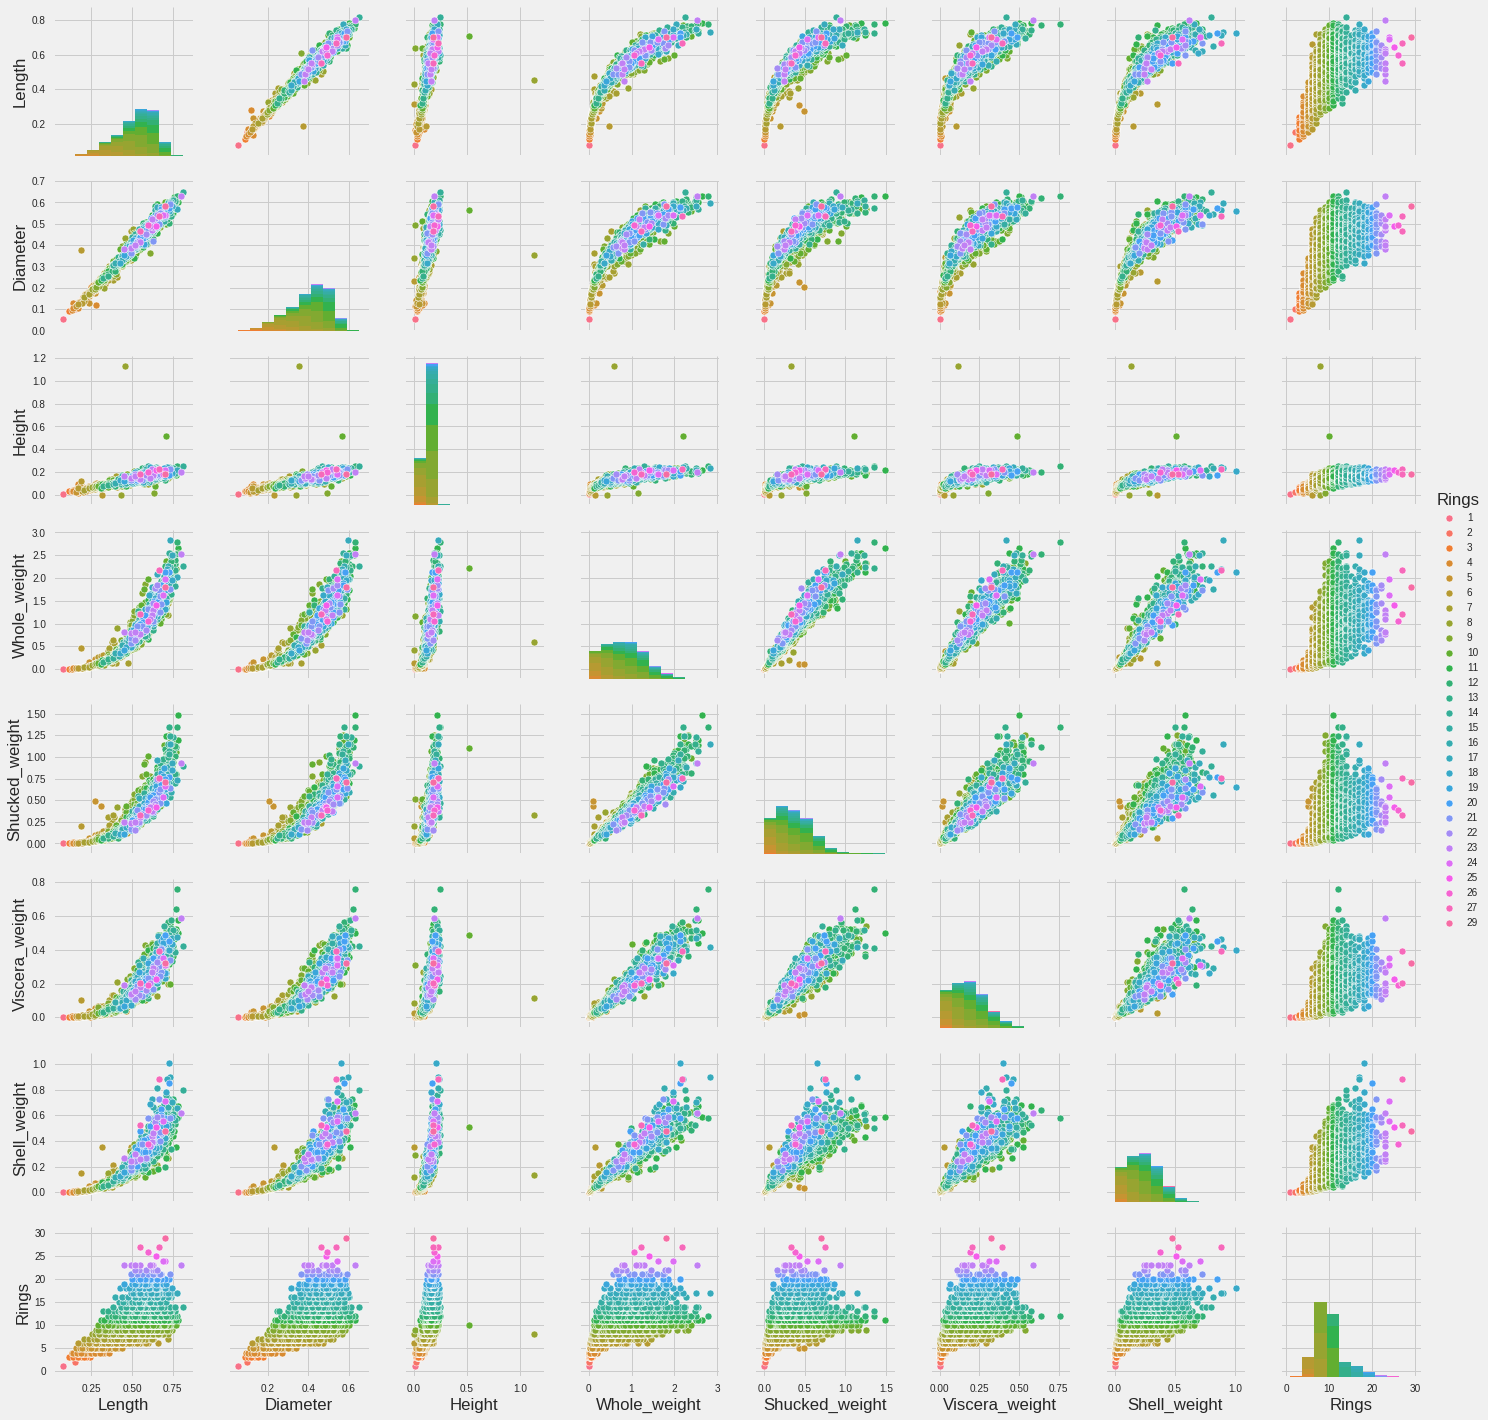

In [64]:
sns.pairplot(data, hue='Rings');

In [0]:
# makeing the label numeric
data.loc[data.Rings <=9, ('Age_Class')] = 0
data.loc[data.Rings >9, ('Age_Class')] = 1

# making the categorical columns numbers via one-hot encoding
data = pd.get_dummies(data)

# selecting out the wanted fields and creating test train splits
X_train, X_test, y_train, y_test = train_test_split(data[['Length', 'Diameter', 'Height', 'Whole_weight', 'Shucked_weight', 'Viscera_weight', 'Shell_weight', 'Sex_F', 'Sex_I', 'Sex_M']], data['Age_Class'], test_size=.33, random_state=42)

In [0]:
model = GradientBoostingClassifier()

In [94]:
model.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

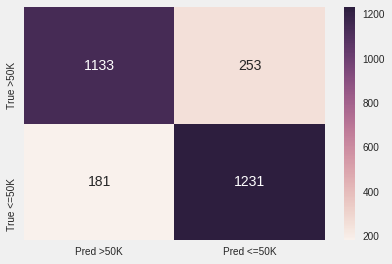

In [105]:
train_pred = model.predict(X_train)
cm_df = pd.DataFrame(confusion_matrix(y_true=y_train, y_pred=train_pred), columns=['Pred >50K', 'Pred <=50K'], index=['True >50K', 'True <=50K'])
sns.heatmap(cm_df,annot=True, fmt='',);

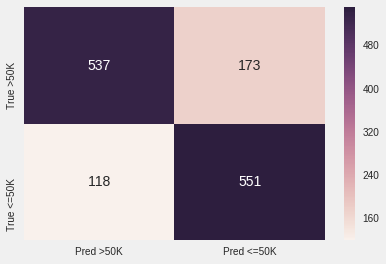

In [106]:
test_pred = model.predict(X_test)
cm_df = pd.DataFrame(confusion_matrix(y_true=y_test, y_pred=test_pred), columns=['Pred >50K', 'Pred <=50K'], index=['True >50K', 'True <=50K'])
sns.heatmap(cm_df,annot=True, fmt='',);

In [107]:
accuracy_score(y_true=y_train, y_pred=train_pred)

0.8448892065761258

In [108]:
accuracy_score(y_true=y_test, y_pred=test_pred)

0.788977519941987

In [109]:
fbeta_score(y_true=y_train, y_pred=train_pred, beta=0.5)

0.8376428960261296

In [110]:
fbeta_score(y_true=y_test, y_pred=test_pred, beta=0.5)

0.7727910238429172